# MODEL SELECTION AND EVALUATION: Part 1

[Introductory Slides](https://docs.google.com/presentation/d/16j_TN0kiiH7aIHcpnrKaQSoViX-68ilCXeQuVzgPY-U/edit#slide=id.p)

This notebook discusses considerations for evaluating classification algorithms in the context of image processing. This is done by considering three classification algorithms:
* Ideal images. The algorithm uses training data to calculate ideal images for each class.
* Feedforward dense neural network. A simple neural network for image classification.
* Multiple-ideal images per class. A generalization of ideal images.

The following are discussed in depth.
* Scope of model evaluation.
* Evaluating the quality of a classifier.
  * Accuracy
  * Recall and precision
  * Confusion matrix
* Other considerations in model evaluation
  * Computational efficiency
  * Conceptual complexity

The notebook is structured using markdown headings to faciliate navigation. The "Helpers" section contains functions used in subsequent sections.

In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import seaborn as sns
import shutil
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical, set_random_seed
from typing import Optional, List

/Users/jlheller/home/Technical/repos/keras/ker/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Colab Setup

Run these cells to get the data needed for this notebook. If you want to run the notebook locally, then you need to have the ``mnist_full`` directory in the same directory as your notebook file.

In [2]:
IS_COLAB = False

In [3]:
if IS_COLAB:
    if not os.path.isdir("mnist_full"):
        !git clone https://github.com/joseph-hellerstein/keras.git
        !unzip keras/data/mnist_full.zip

# Helpers

## Constants

In [4]:
NUM_DIGIT = 10
NUM_TRAINING = 1000
TRAINING = "training"
TESTING = "testing"
if IS_COLAB:
    DATA_DIR = "."
else:
    # Replace this path with your local path to the mnist_full directory
    DATA_DIR = "/Users/jlheller/home/Technical/repos/keras/data"
DATA_MNIST_FULL = os.path.join(DATA_DIR, "mnist_full")
DATA_MNIST_SMALL = os.path.join(DATA_DIR, "mnist_small")

## copyFiles

In [5]:
def copyFiles(from_dir:str, to_dir:str, num_files:int, is_symlink:bool=True):
    """
    Selects a random subset of models in a directory and copies them to another directory.

    Args:
        from_dir: The directory to select files from.
        to_dir: The directory to copy files to.
        num_files: The number of files to copy. if < 0, all files are copied.
        is_symlink: If True, creates a symbolic link to the file.
    """
    if not os.path.exists(from_dir):
        raise ValueError("Directory %s does not exist." % from_dir)
    if not os.path.exists(to_dir):
        os.makedirs(to_dir)
    ffiles = os.listdir(from_dir)
    if num_files < 0:
        num_files = len(ffiles)
    if num_files >= len(ffiles):
        sel_ffiles = ffiles
    else:
        idxs = np.random.choice(len(ffiles), num_files, replace=False)
        sel_ffiles = [ffiles[idx] for idx in idxs]
    for ffile in sel_ffiles:
        file_path = os.path.join(from_dir, ffile)
        new_file_path = os.path.join(to_dir, ffile)
        if is_symlink:
            os.symlink(file_path, new_file_path)
        else:
            shutil.copy(file_path, new_file_path)

## makeDigitDirs

In [6]:

def makeDigitDirs(train_count:Optional[int]=100, test_count:Optional[int]=None, root_from_dir:str=DATA_MNIST_FULL,
             root_to_dir:str=DATA_MNIST_SMALL, sub_dirs:List[str]=["0"]):
    """
    Creates training and test directories of the specified sizes

    Args:
        train_count: The number of training files.
        test_count: The number of test files.
    """
    if test_count is None:
        test_count = int(0.2*train_count)
    if len(sub_dirs) == 0:
        sub_dirs = [str(n) for n in range(NUM_DIGIT)]
    is_error = False
    try:
        trues = [int(d) in range(NUM_DIGIT) for d in sub_dirs]
    except:
        is_error = True
    if is_error or not all(trues):
        raise ValueError("Directories must be integers between 0 and %d." % (NUM_DIGIT - 1))
    #
    count_dct = {TRAINING: train_count, TESTING: test_count}
    for phase_name in [TESTING, TRAINING]:
        phase_dir = os.path.join(root_to_dir, phase_name)
        if os.path.exists(phase_dir):
            shutil.rmtree(phase_dir)
        for sub_dir in sub_dirs:
            from_dir = os.path.join(root_from_dir, phase_name, str(sub_dir))
            to_dir = os.path.join(root_to_dir, phase_name, str(sub_dir))
            if os.path.exists(to_dir):
                shutil.rmtree(to_dir)
            os.makedirs(to_dir)
            copyFiles(from_dir, to_dir, count_dct[phase_name])  # type: ignore

# Tests
makeDigitDirs()

## getKey

In [7]:
def getKey(dct):
    keys = list(dct.keys())
    return keys[0]

# Tests
key = 4
dct = {key: range(10)}
assert(getKey(dct) == key)
print("OK!")

OK!


## plotConfusionMatrix

2024-04-22 13:41:44.434319: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-04-22 13:41:44.434338: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-04-22 13:41:44.434342: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-04-22 13:41:44.434364: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-22 13:41:44.434375: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


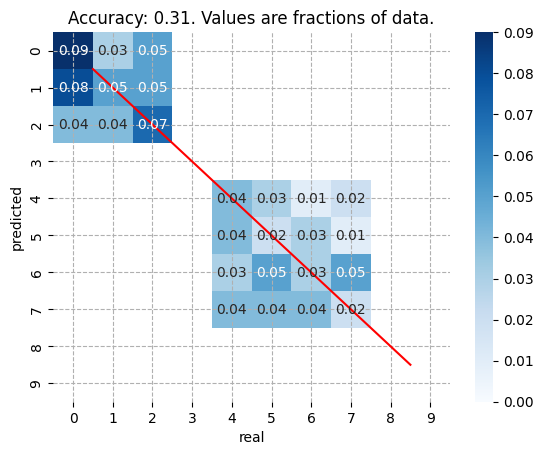

In [8]:
def plotConfusionMatrix(y_true:np.ndarray[int], y_pred:np.ndarray[int]):
    """
    Plots the confusion matrix for the classifications. Values are fraction of data.

    Args:
        y_true: True labels
        y_pred: Predicted labels
    """
    NUM_DIGIT = 10
    labels = set(y_true)
    num_label = NUM_DIGIT
    data_len = len(y_true)
    mat = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_label)
    frc_mat = np.round(mat/data_len, 2)
    mask_mat = np.repeat(True, num_label*num_label)
    mask_mat = np.reshape(mask_mat, (num_label, num_label))
    for yt in range(num_label):
        for yp in range(num_label):
            if not np.isclose(frc_mat[yp, yt], 0):
                mask_mat[yp, yt] = False
    #
    _ = sns.heatmap(np.transpose(frc_mat), cmap="Blues", annot=True,
                    annot_kws={'fontsize': 10},
                    mask=np.transpose(mask_mat),
                 vmin=0)
    accuracy = np.round(balanced_accuracy_score(y_true, y_pred), 2)
    plt.grid(linestyle="--")
    plt.ylabel("predicted")
    plt.xlabel("real")
    plt.plot(range(1, num_label), range(1, num_label), c="red")
    plt.title("Accuracy: {accuracy}. Values are fractions of data.".format(accuracy = accuracy))
    plt.show()

# Tests
def mkydata(num_label=8, size=100):
    labels = list(range(num_label))
    if num_label < 4:
        raise ValueError("num_label > 3")
    missing_label = labels[3]
    y1 = np.random.randint(0, missing_label, size//2)
    y2 = np.random.randint(missing_label+1, num_label, size//2)
    return np.concatenate([y1, y2])
#
size = 100
y_true = mkydata()
y_pred = mkydata()
plotConfusionMatrix(y_true, y_pred)

## makeDigitData

In [9]:
def makeDigitData(datatype:str)->(np.ndarray, np.ndarray):
    """
    Uses last construction of the digit data. The image is flattened.

    Args:
        datatype: "testing", "training"
    Returns:
        ndarray: feature matrix
        ndarray: label vector
    """
    small_path = os.path.join(DATA_MNIST_SMALL, datatype)
    full_path = os.path.join(DATA_MNIST_FULL, datatype)
    ddirs = os.listdir(small_path)
    X_data = []
    y_arr = np.array([])
    for ddir in ddirs:
        this_small_ddir = os.path.join(small_path, ddir)
        this_full_ddir = os.path.join(full_path, ddir)
        ffiles = os.listdir(this_small_ddir)
        label_arr = np.repeat(int(ddir), len(ffiles))
        y_arr = np.concatenate((y_arr, label_arr))
        for ffile in ffiles:
            path = os.path.join(this_full_ddir, ffile)
            img = Image.open(path)
            mat = np.asarray(img)
            arr = mat.flatten()
            X_data.append(arr)
    X_mat = np.stack(X_data)
    y_arr = y_arr.astype(int)
    return X_mat, y_arr

# Tests
X_mat, y_data = makeDigitData(TRAINING)
num_sample = np.shape(X_mat)[0]
assert(num_sample == np.shape(y_data)[0])
print("OK!")

OK!


## displayImage

In [10]:
def displayImage(dcts, rpix=28, cpix=28, nrow=2, ncol=5, is_plot=True, fontsize=14):
    """
    args:
        dcts: list-dict (key: digit, value: array)
        rpix: int (row pixels)
        cpix: int (column pixels)
        nrow: int (number of rows in the plot)
        ncol: int (number of columns in the plot)
        fontsize: int (size of title font; no title if =< 0)
    """
    if is_plot:
        _, axes = plt.subplots(nrow, ncol, figsize=(20, 15))
    for irow in range(nrow):
        for icol in range(ncol):
            if is_plot:
                ax = axes[irow, icol]
            pos = irow*ncol + icol
            if pos > len(dcts) - 1:
                break
            dct = dcts[pos]
            digit = list(dct.keys())
            digit = digit[0]
            arr = dct[digit]
            img_arr = np.reshape(arr, (rpix, cpix))
            img = Image.fromarray(img_arr)
            if is_plot:
                ax.imshow(img)
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                if fontsize > 0:
                    ax.set_title("%d" % digit, fontsize=fontsize)

# Tests
rpix = 28
cpix = 28
dcts = []
for digit in range(7):
    dct = {digit: np.uint8(np.random.randint(0, 255, rpix*cpix))}
    dcts.append(dct)
displayImage(dcts, rpix=rpix, cpix=cpix, is_plot=False)
print("OK!")

OK!


## learnDigits

***Preparing the data. This can take 30 secs for so.
***Making in-memory test and training data.
***Constructing the model.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,687 (108.15 KB)

 Trainable params: 27,687 (108.15 KB)

 Non-trainable params: 0 (0.00 B)

***Training the model.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


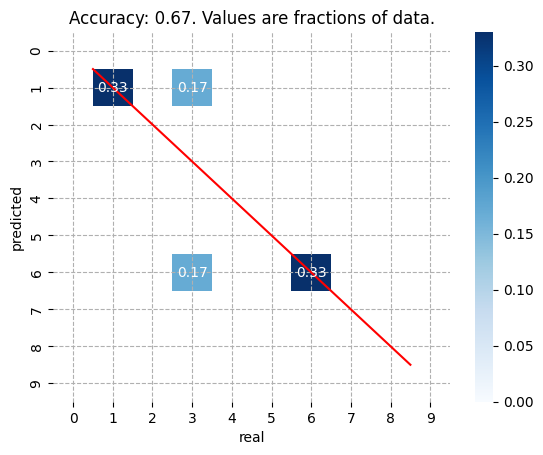

***Constructing the model.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,687 (108.15 KB)

 Trainable params: 27,687 (108.15 KB)

 Non-trainable params: 0 (0.00 B)

***Training the model.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


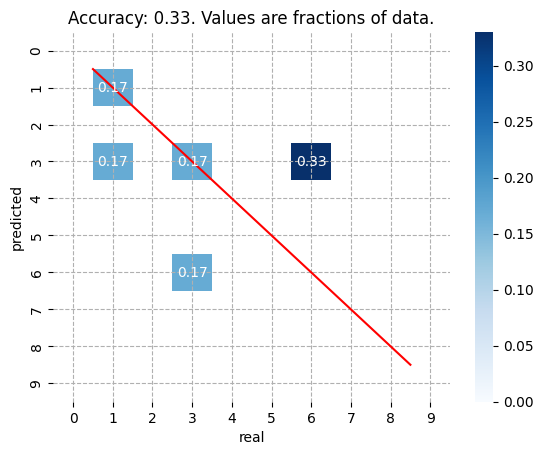

***Preparing the data. This can take 30 secs for so.
OK!


In [11]:
global X_training, y_training, X_testing, y_testing
LearnerInfo = collections.namedtuple("LearnerInfo",
      "model, X_training, y_training, X_testing, y_testing, history"
                                    )
def learnDigits(
    training_count:Optional[int]=None,
    digits:List[int]=range(10),
    hidden1_size:int=8,
    hidden2_size:int=16,
    num_epoch:int=5,
    training_verbose:int=0,
    is_confusion_matrix=True,
    is_model_summary=True,
):
    """
    1. Creates the data for the model from the full MNIST dataset.
    2. Constructs a sequential model with specified sizes of hidden layers
    3. Does prediction for the test set (20% the size of the training data)
    4. Displays accuracy and confusion matrix.

    Args:
        training_count: int (number of training images for each class)
            if None, use existing data.
        digits: list-int (digits/classes considered)
        hidden1_size: int (number of units in the first hidden layer)
        hidden2_size: int (number of units in the second hidden layer)
        num_epoc: int (number of epochs of training)
        verbose: int (verbosity for training)
    Returns:
        LearnerInfo
    """
    global X_training, y_training, X_testing, y_testing
    def makeDirs(error_msg=None):
        print("***Preparing the data. This can take 30 secs for so.")
        if training_count is None:
            if error_msg is None:
                error_msg = "Must specify training count to acquire new data."
            raise ValueError(error_msg)
        sub_dirs = [str(n) for n in digits]
        makeDigitDirs(train_count=training_count, sub_dirs=sub_dirs)
    #
    # Create the input data
    is_new_data = False
    if training_count is not None:
        makeDirs()
        is_new_data = True
    # Construct training and test data
    if (not "X_testing" in globals()) or is_new_data:
        print("***Making in-memory test and training data.")
        X_training, y_training = makeDigitData(TRAINING)
        X_testing, y_testing = makeDigitData(TESTING)
        is_new_data = True
    digit_diff = set(y_training).symmetric_difference(digits)
    if len(digit_diff) > 0:
        makeDirs(error_msg="Changed digits but didn't specify training_count.")
        X_training, y_training = makeDigitData(TRAINING)
        X_testing, y_testing = makeDigitData(TESTING)
    # Construct the model
    print("***Constructing the model.")
    max_class = max(y_training) + 1
    model = keras.Sequential(
        [
            keras.Input(shape=(X_training.shape[-1],)),
            layers.Dense(hidden1_size, activation="relu"),
            layers.Dense(hidden2_size, activation="relu"),
            layers.Dense(max_class, activation="softmax"),
        ]
    )
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    if is_model_summary:
        model.summary()
    categorical_y_training = to_categorical(y_training)
    # Train the model
    print("***Training the model.")
    history = model.fit(X_training, categorical_y_training, epochs=num_epoch,
                        batch_size=64,
                        verbose=training_verbose)

    y_pred = model.predict(X_testing).argmax(axis=1)
    # Evaluate the result
    if is_confusion_matrix:
        plotConfusionMatrix(y_testing, y_pred)
    return LearnerInfo(
        X_training=X_training,
        y_training=y_training,
        model=model,
        X_testing=X_testing,
        y_testing=y_testing,
        history=history
    )

# Tests
try:
    learner_info = learnDigits(training_count=10, hidden1_size=32, hidden2_size=64,
            num_epoch=5, digits = [1, 3, 6], training_verbose=0)
except Exception as e:
    assert(False)
# Use previous data
try:
    learnDigits(training_count=None, hidden1_size=32, hidden2_size=64,
            num_epoch=5, digits = [1, 3, 6], training_verbose=0)
except Exception as e:
    assert(False)
# Changed digits
try:
    learnDigits(training_count=None, hidden1_size=32, hidden2_size=64,
            num_epoch=5, digits = [1, 3, 6, 7], training_verbose=0)
    assert(False)
except Exception as e:
    pass
#
print("OK!")

In [12]:
learner_info.X_testing[0:1, :]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  10, 128, 255, 134,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 110, 252, 209,
         28,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  45, 240,
        164,  25,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [13]:
learner_info.model.predict(learner_info.X_testing[0:1, :]).argmax(axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([6])

In [14]:
set(learner_info.y_testing)

{1, 3, 6}

In [15]:
np.shape(learner_info.X_testing[0:2, :])

(2, 784)

In [16]:
np.shape(learner_info.X_testing)

(6, 784)

## Cluster codes

In [17]:
def plotSSW(digit, sizes=None, ax=None, is_plot=True):
    """
    Plots the sum of squares within the classes

    Args:
        digit - int
    Returns:
        KMeans
    """
    if sizes is None:
        sizes = [1, 5, 8, 10, 12, 15, 18, 20, 30, 40, 50]
    ssq_dct = {}
    for size in sizes:
        idxs = Y_TRAINING_ARR == digit
        kmeans = KMeans(n_clusters=size, random_state=0, n_init="auto").fit(X_TRAINING_MAT[idxs, :])
        ssq_dct[size] = kmeans.inertia_
    if is_plot:
        if ax is None:
            _, ax = plt.subplots(1)
        ax.plot(ssq_dct.keys(), ssq_dct.values())
        ax.set_title(str(digit), fontsize=20)
        ax.set_xlabel("no. classes")
        ax.set_ylabel("sum of squares")
        ax.set_ylim([0, 2*1e10])
    return kmeans

# Tests
if not "Y_TRAINING_ARR" in globals():
    print("NO TEST.")
else:
    result = plotSSW(1, sizes=[1,3], is_plot=False)
    assert("KMeans" in str(type(result)))
    print("OK!")

NO TEST.


In [18]:
def plotDigitClassSizes(is_plot=True, **kwargs):
    """
    Plots the class sizes and SSW.

    Returns:
        list-KMeans
    """
    nrow = 2
    ncol = 5
    if is_plot:
        figure, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
    kmeans = []
    for irow in range(nrow):
        for icol in range(ncol):
            digit = irow*ncol + icol
            if is_plot:
                ax = axes[irow, icol]
            else:
                ax = None
            kmeans.append(plotSSW(digit, ax=ax, is_plot=is_plot, **kwargs))
            if irow == 0:
                if ax is not None:
                    ax.set_xlabel("")
            if icol > 0:
                if ax is not None:
                    ax.set_ylabel("")
    return kmeans

# Tests
if not "Y_TRAINING_ARR" in globals():
    print("NO TEST.")
else:
    results = plotDigitClassSizes(sizes=[1, 20], is_plot=False)
    assert(isinstance(results, list))
    assert("KMeans" in str(type(results[0])))
    print("OK!")

NO TEST.


## Data Initialization

In [19]:
%%time
makeDigitDirs(train_count=NUM_TRAINING, sub_dirs=range(10))
X_TRAINING_MAT, Y_TRAINING_ARR =  makeDigitData(TRAINING)
X_TESTING_MAT, Y_TESTING_ARR =  makeDigitData(TESTING)

CPU times: user 971 ms, sys: 1.19 s, total: 2.17 s
Wall time: 6.33 s


In [20]:
np.shape(X_TRAINING_MAT), np.shape(Y_TRAINING_ARR), np.shape(X_TESTING_MAT), np.shape(Y_TESTING_ARR)

((10000, 784), (10000,), (2000, 784), (2000,))

In [21]:
X_TRAINING_MAT[0:2, 100:200]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        123, 254, 172,  92,  10,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 163, 243, 253, 252, 253, 172,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [22]:
Y_TRAINING_ARR[0:2]

array([9, 9])

# An Anecdote on Data Curation

Task: Build a learner that classifies an image as a *plane* or a *bird*.

Data collection with ``duckduckgo`` searching for images with the keywords "bird" and "plane".

<img src="https://pngimg.com/uploads/birds/birds_PNG49.png" alt="drawing" width="200"/>
<img src="https://i.etsystatic.com/18604024/r/il/d40c9f/4484408200/il_1588xN.4484408200_rfpk.jpg" alt="drawing" width="200"/>
<img src="https://pngimg.com/uploads/plane/plane_PNG101208.png" alt="drawing" width="200"/>

There was one unexpected image retrieved for the "bird" search.

**Larry Bird**
<img src="https://cdn.nba.com/manage/2018/10/larry-bird.jpg" alt="drawing" width="300"/>

We don't want pictures of Larry Bird in our training data!

**Data curation is essential.**

# MNIST Digit Data

From Wikipedia:

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. It was created by "re-mixing" the samples from NIST's original datasets. The creators felt that since NIST's training dataset was taken from American Census Bureau employees, while the testing dataset was taken from American high school students, it was not well-suited for machine learning experiments. Furthermore, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png" alt="drawing" width="400"/>

About 6,000 ``png` files for training each digit and 1,000 ``png`` files for testing.

<img src="https://github.com/joseph-hellerstein/keras/raw/main/docs/structure-of-mnist.png" alt="drawing" width="800"/>

# Common Sense Data Science for Classification

## Terminology

* **Data.** Information collected for analysis. They described along two dimensions:
    * **Sample instance (data item)** An instance of what is collected. Example: A single $28 \times 28$ image.
    * **Feature.** An attribute of a data item. Example: pixel 25, 27.
    * **Label.** A classification of a data item. Example (for digit classification): "5".
* **Fit Algorithm.** Procesing data in preparation for analysis.
    * **Parameters.** Constants estimated by the fit algorithm.
    * **Training data.** Data used by the learner to estimate parameters (e.g., via back propagation).
    * **Validation data.** Data used to evaluate model quality during testing. These data must be separate from training data.
* **Predict Algorithm.** An algorithm that inputs data features and outputs a label.
* **Evaluation.** An assessment of the model's ability to perform its intended task based on considerations such as: (a) the quality of the predictions; (b) computational efficiency; and (c) conceptual complexity.
    * **Testing data.** Data with known labels used in evaluation (but not in the fit algorithm).

## Guidelines

**You need much more data (number of samples times features) than parameters.**
Violating this leads to overfitting.

**Models should have as many parameters as required to achieve the desired quality (e.g., accuracy), but no more.**
This reduces the data requirements and the complexity of the model.

**A data item improves parameter estimation only if it provides new information.** There is no value to redundant data.

**We prefer models that have an intuitive explanation.** Intuitive models are more credible than a "black box".

# Tips for Computational Sanity

## Recommendations

1. Global variables
    1. Definition: Write once, read many in many cells.
    1. Names have all capital letters.
1. Local variables
    1. Definition: Used within a single cell
    2. Names are all lower case.
1. Functions
    1. Use functions to encapsulate workflow and avoid "name collisions" for variables.
    2. Functions definitions include a test (``assert``)

## Globals in this notebook

The globals reflect training and test data for MNIST.

In [23]:
np.shape(X_TESTING_MAT), np.shape(Y_TESTING_ARR)

((2000, 784), (2000,))

# What is a classification model?

<img src="https://github.com/joseph-hellerstein/keras/raw/main/docs/easy_classification_1.png" alt="drawing" width="500"/>

A classification model is an algorithm that distinguishes between the labels. One approach is to draw lines.
<img src="https://github.com/joseph-hellerstein/keras/raw/main/docs/easy_classification_2.png" alt="drawing" width="500"/>

However, the lines are more complex curves for more difficult classification problems.
<img src="https://github.com/joseph-hellerstein/keras/raw/main/docs/hard_classification.png" alt="drawing" width="500"/>

An approach that can work fairly well for not too difficult problems is to calculate average values of features for each class. The predicated class for a data item is the class whose average feature is closest.
<img src="https://github.com/joseph-hellerstein/keras/raw/main/docs/averaged_sample_algorithm.png" alt="drawing" width="500"/>

# Model 1: Ideal Digits

## Approach - Ideal Image

* *Fit Algorithm*: Calculate the "ideal" for each class, the average value of each of the $28 \times 28$ pixels for all images in each class.
* *Predict Algorithm*: Choose the digit whose ideal image has the smallest distance from the test image.

Distance measure. Let $\bar{p}_{ki}$ be the $i$-th pixel of the ideal image of class $k$, and let $p_{i}$ be the $i$-th pixel in a test image. The distance $d_k$ from the test image to the ideal of class $k$ is
$$d_k = \sum_i (p_i - \bar{p}_{ki})^2$$.

**Fit Algorithm**: Calculate $\bar{p}_{ki}$ for all classes $k$.

**Predict Algorithm**: $k^{\star} = argmin~ d_k$

## Fit Algorithm

    for digit in digits
        digit_ideal_image = mean of pixels for digit
        ideal_images.append(digit_ideal_image)
    return ideal_images

In [24]:
def fitIdeal(training_count=600, num_cluster=1):
    """
    Constructs ideal images and their classes.

    Args:
        training_count: int (size of the training set for a digit)
        num_cluster: int (number of clusters in a digit training set)

    Returns:
        list-dict (key: digit, value: array of mean pixels)
    """
    dcts = []
    for digit in range(10):
        makeDigitDirs(train_count=training_count, sub_dirs=[digit])
        X_training, _ = makeDigitData(TRAINING)
        if num_cluster == 1:
            dct = {digit: np.mean(X_training[:, :], axis=0)}
            dcts.append(dct)
        else:
            kmeans = KMeans(n_clusters=num_cluster, random_state=0, n_init="auto").fit(X_training)
            for cluster_center in kmeans.cluster_centers_:
                dct = {digit: cluster_center}
                dcts.append(dct)
    return dcts

# Tests
dcts = fitIdeal(training_count=10)
assert(isinstance(dcts, list))
assert(isinstance(dcts[0], dict))
if False:
    displayImage(dcts)
else:
    print("OK!")

OK!


In [25]:
%%time
FITTED_DCTS = fitIdeal(training_count=NUM_TRAINING)

CPU times: user 881 ms, sys: 1.5 s, total: 2.38 s
Wall time: 7.73 s


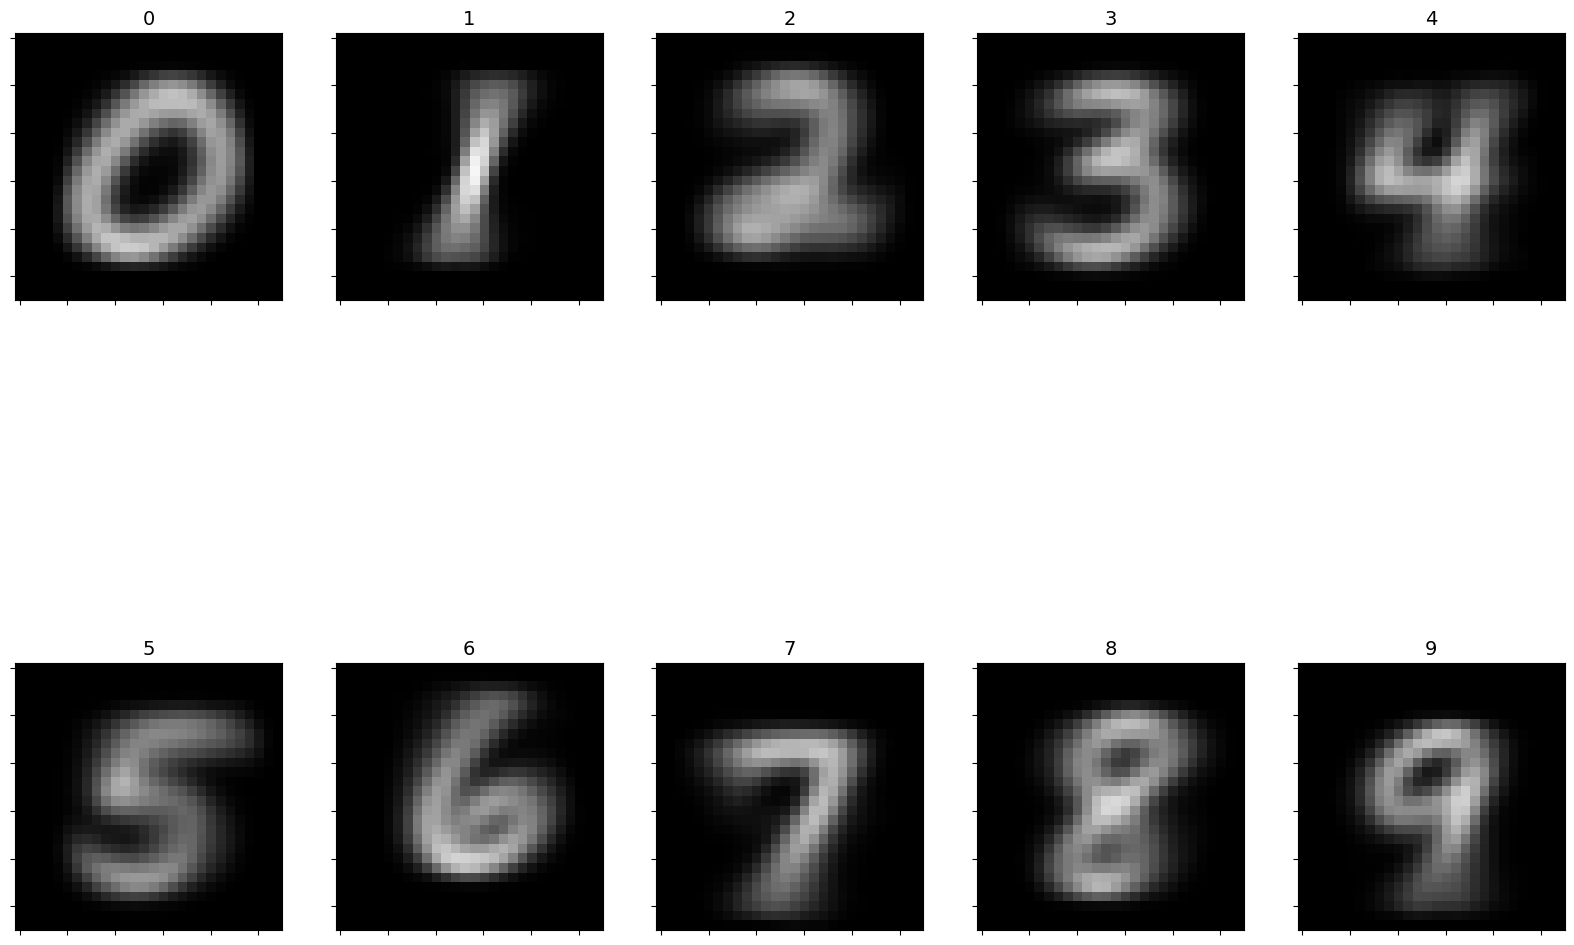

In [26]:
displayImage(FITTED_DCTS)

The parameters in this model are the average pixels.

## Predict Algoirthm

    for digit_ideal_image in ideal_images
        distance[digit] = (test_image - digit_ideal_image)**2
    return digit with the smallest distance

In [27]:
def predictIdeal(test_X_mat, dcts=FITTED_DCTS):
    """
    Predicts the classes for the flattened_test_arr

    Args:
        test_X_mat: mat-int (x, 768)
        dcts: list-dict (key: digit, value: array)
    Returns:
        arr-int (predictions)
    """
    num_test = np.shape(test_X_mat)[0]
    num_ideal = len(dcts)
    # Construct the fitted data
    digit_arr = np.array([getKey(d) for d in dcts])
    centroid_mat = np.array([d[k] for d, k in zip(dcts, digit_arr)])
    predictions = []
    for test_idx in range(num_test):
        test_arr = test_X_mat[test_idx, :]
        distance_mat = np.subtract(centroid_mat, test_arr)
        distance_mat = np.multiply(distance_mat, distance_mat)
        distance_arr = np.sum(distance_mat, axis=1)
        min_pos = distance_arr.argmin()
        predictions.append(digit_arr[min_pos])
    # Calculate predictions
    return np.array(predictions)

# TESTS
matches = predictIdeal(X_TESTING_MAT) - Y_TESTING_ARR
accuracy = np.sum([v == 0 for v in matches])/len(matches)
assert(accuracy >= 0.8)
print("OK!")

OK!


# Evaluating Model Quality

## Accuracy

Accuracy is the fraction of the test set for which the predicted label is the real label. This is useful for "one shot" classification.

In [28]:
# Calculate Accuracy
def calculateAccuracy(real_labels, pred_labels):
    """
    Calculates the accuracy of a classifier.

    Args:
        real_labels: np.ndarray (correct labels)
        pred_labels: np.ndarray (predicted labels)
    Returns:
        float: accuracy
    """
    return np.sum(real_labels == pred_labels)/len(real_labels)

# Tests
pred_labels = predictIdeal(X_TESTING_MAT)
real_labels = Y_TESTING_ARR
accuracy = calculateAccuracy(real_labels, pred_labels)
assert(isinstance(accuracy, float))
print("OK!")

OK!


In [29]:
print("Accuracy is %f" % calculateAccuracy(Y_TESTING_ARR, predictIdeal(X_TESTING_MAT)))

Accuracy is 0.808500


## Precision and Recall

For retrieval tasks, we are doing classification of many data items. An example of this is an Internet search for web pages with desired phrases or synonyms for these terms. This is a binary classification. That is, web pages are classified as either relevant or irrelevant to the query. We refer to the former as *positive (pos)* and the latter as *negative (neg)*.

The query algorithm uses the predict algorithm as follows:

    for data_item in data:
        if predict(data_item) in desired class
            output the data_item

Because the foregoing operates on a batch of samples, we have slightly different metrics than the "single shot" scenario.
          
* **Precision**: What fraction of the output data are *true* members of the desired class
* **Recall**: What fraction of all data in the true class are in the output data

**Query: Find all zeros in this corpus.**

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png" alt="drawing" width="400"/>

<img src="https://github.com/joseph-hellerstein/keras/raw/main/docs/query.png" alt="drawing" width="800"/>

* **True positive** The real label is "pos", and "pos" is predicted.
* **False positive** The real label is "neg", but "pos" is predicted.
* **False negative** The real label is "pos", but "neg" is predicted.
* **False positive** (negative). The real label is "neg", and "neg" is predicted.

<img src="https://github.com/joseph-hellerstein/keras/raw/main/docs/table.png" alt="drawing" width="800"/>

In [30]:
def calculatePrecisionRecall(label, real_arr, pred_arr):
    """
    Calculates precision for the digit, the fraction of true positives.

    Args:
        label: int (label for which a query is done)
        real_arr: np.array-int (correct labels)
        pred_arr: np.ndarray-int (predicted labels)
    Returns:
        float: precision
        float: recall
    """
    # Initial statistics (columns and rows of the above table)
    real_positives = real_arr == label  # Array of booleans
    real_negatives = real_arr != label
    pred_positives = pred_arr == label
    pred_negatives = pred_arr != label
    # Calculate cells of the table
    tp = np.sum(np.logical_and(real_positives, pred_positives))
    fp = np.sum(np.logical_and(real_negatives, pred_positives))
    fn = np.sum(np.logical_and(real_positives, pred_negatives))
    tn = np.sum(np.logical_and(real_negatives, pred_negatives))
    # Calculate metrics
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    return precision, recall

# Tests
pred_arr = predictIdeal(X_TESTING_MAT)
real_arr = Y_TESTING_ARR
precision, recall = calculatePrecisionRecall(1, real_arr, pred_arr)
for value in [precision, recall]:
    assert(isinstance(value, float))
print("OK!")

OK!


In [31]:
for digit in range(10):
    precision, recall = calculatePrecisionRecall(digit, real_arr, pred_arr)
    print("%d: precision=%f recall=%f" % (digit, precision, recall))

0: precision=0.896907 recall=0.870000
1: precision=0.758893 recall=0.960000
2: precision=0.870056 recall=0.770000
3: precision=0.763285 recall=0.790000
4: precision=0.785366 recall=0.805000
5: precision=0.779006 recall=0.705000
6: precision=0.850000 recall=0.850000
7: precision=0.895604 recall=0.815000
8: precision=0.763736 recall=0.695000
9: precision=0.753425 recall=0.825000


### F1 score

The F1-score combines precision and recall to produce a single number by calculating the harmonic mean of precision and recall.

$$ F1 = [(1/precision + 1/recall)/2]^{-1}$$

## Confusion Matrix

### Background and definitions

The confusion matrix provides a general way to analyze the quality of a classifier for multiple classification problems. You can easily calculate accuracy, precision, and recall from the confusion matrix.

As with precision and recall, we are looking for discrepancies between the true value of a label and its predicted value. Again, this is presented as a table; the columns are true labels, and the rows are predicted labels. However, since we have more than two labels, we have more than two rows and columns. Entries in the table can be the number of data items that have a particular combination of true label and predicted label. I often find it more convenient to use the *fraction* of data items.

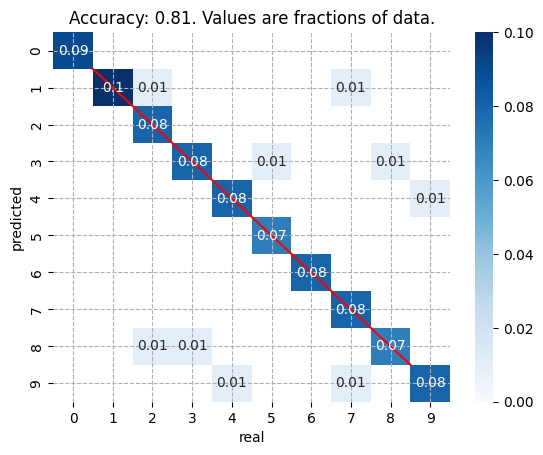

CPU times: user 331 ms, sys: 7.59 ms, total: 339 ms
Wall time: 140 ms


In [32]:
%%time
y_pred_arr = predictIdeal(X_TESTING_MAT, dcts=FITTED_DCTS)
plotConfusionMatrix(Y_TESTING_ARR, y_pred_arr)

### Deriving accuracy, precision, recall from the confusion matrix

Accuracy is the sum of the diagnonal.

The precision for label $k$ is the value at $(k,k)$ divided by all values row $k$.

The recall for label $k$ is the value at $(k, k)$ divided by all values in column $k$.

**Questions**
1. Calculate the recall for "1" using the data in the table and compare it with ``calculatePrecisionRecall``. (Entries in the table are rounded.)
2. Which of the following digits have the largest precision: 0, 1, 5? Which has the smallest?

# Evaluating Model Complexity

Complexity is often connected with **understanding**. Do we understand how the model works with sufficient detail so that we can improve it and understand its limitations? This is largely a subjective analysis.

A second perspective on complexity is quantitative: **the number of parameters in the model**. Since all empirical models have parameters that must be estimated, a model with more parameters is typically considered more complex. The implications here are more than subjective. Having more parameters means that we must have more data to be able to estimate the parameters. It often means that there are efficiency considerations as well in terms of estimating the parameters with sufficient accuracy.

Let's evaluate the complexity of the ideal image model. Do we understand how the model works, its limitations, and how to improve it?
  1. The model is represented by the "average images" for each digit.
  2. It works well if: (a) digits are written like their "averages" and (b) "average images" are sufficiently different from one another.

The number of parameters in the model is the number of ideal images times the number of pixels in an image. There are 10 ideal images and $28 \times 28 = 784$ pixels in each image. So, there are a total of 7,640 parameters.

# Evaluating Computational Efficiency

Simple benchmark
* Fit the model
* Calculate the confusion matrix for X_TESTING_MAT
* Report: number of parameters (1000s), time (seconds), accuracy

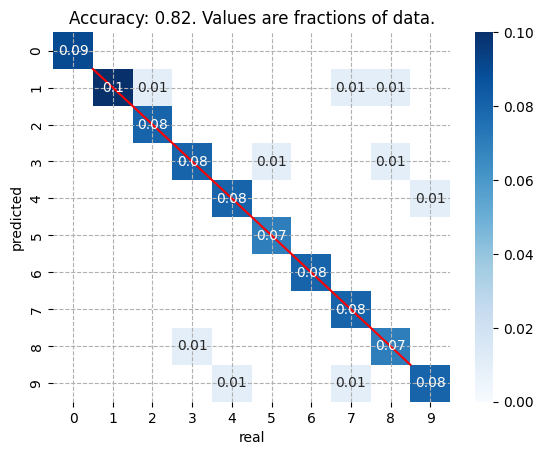

CPU times: user 1.5 s, sys: 1.51 s, total: 3.01 s
Wall time: 8.28 s


In [33]:
%%time
fitted_dcts = fitIdeal(training_count=NUM_TRAINING)
y_pred_arr = predictIdeal(X_TESTING_MAT, dcts=fitted_dcts)
plotConfusionMatrix(Y_TESTING_ARR, y_pred_arr)

# Model 2: Neural Network

## Model

<img src="https://github.com/joseph-hellerstein/keras/raw/main/docs/neural_network.png" alt="drawing" width="800"/>

***Preparing the data. This can take 30 secs for so.
***Making in-memory test and training data.
***Constructing the model.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

***Training the model.
Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2039 - loss: 12.6773
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4553 - loss: 8.4840
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5287 - loss: 7.4489
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5495 - loss: 7.1455
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5577 - loss: 7.0033
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5641 - loss: 6.9276
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5562 - loss: 7.0473
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5721 - loss: 6.8248
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5751 - loss: 6.7910
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5581 - loss: 7.0617
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5749 - loss: 6.7950
Epoch 12/50
157/157 ━━━━━━━━

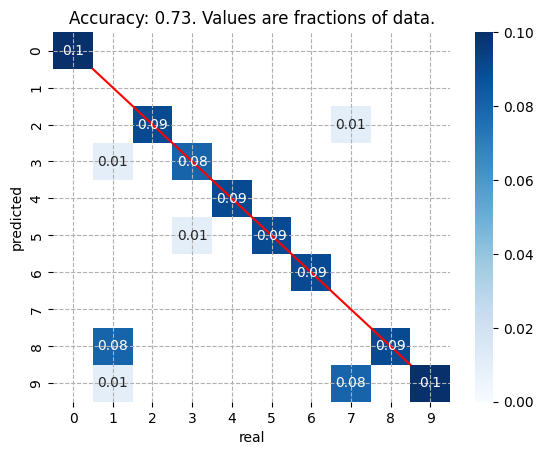

CPU times: user 27.8 s, sys: 1min 14s, total: 1min 42s
Wall time: 27.7 s


In [34]:
%%time
learner_info = learnDigits(
    training_count=NUM_TRAINING,
    training_verbose=1,
    hidden1_size=32,
    hidden2_size=32,
    is_confusion_matrix=True,
    num_epoch=50,
)

Results:
* Parameters (1000s): 26.5
* Time (seconds): 14
* Accuracy (fraction): 0.85

See if you can do better by adjusting the hidden units. Put your results [here](https://docs.google.com/spreadsheets/d/11LoDehwI2uNwiH2bBsVB6zBenTEAn18cOzrQztKrm3s/edit?usp=sharing).

# Model 3: Multiple Ideal Images for a Digit

Approach -- Have more than one ideal image for each digit to account for variations in writing digits.

More ideal images likely improves model quality. But it also increases the number of parameters.

## Clustering

<img src="https://github.com/joseph-hellerstein/keras/raw/main/docs/clusters.png" alt="drawing" width="800"/>

In [35]:
#_ = plotDigitClassSizes() # Takes a long time

<img src="https://github.com/joseph-hellerstein/keras/raw/main/docs/ssw_by_num_classes.png" alt="drawing" width="1200"/>

## Approach - Ideal image for each cluster

**Model 1 Fit Algorithm**

    for digit in digits
        digit_ideal_image = mean of pixels for digit
        ideal_images.append(digit_ideal_image)
    return ideal_images

**Model 3 Fit Algorithm**

    for digit in digits:
        for cluster in clusters for digit
            cluster_ideal_image = mean of pixels in digit cluster
            ideal_images.append(cluster_ideal_image)
    return ideal_images

**Predict Algorithm (same as Model 1)**

## Model Quality

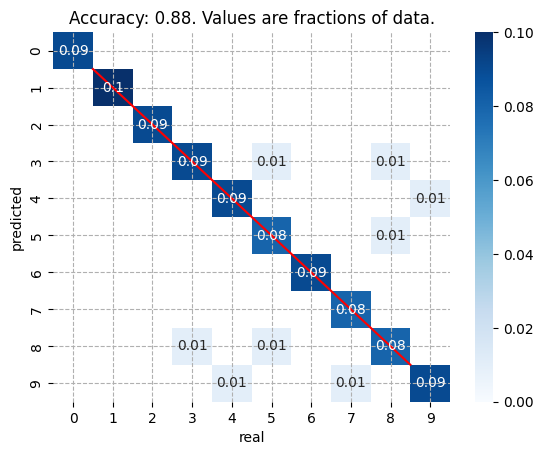

CPU times: user 8.73 s, sys: 22.2 s, total: 30.9 s
Wall time: 10.9 s


In [36]:
%%time
NUM_CLUSTER = 4
fitted_dcts = fitIdeal(training_count=NUM_TRAINING, num_cluster=NUM_CLUSTER)
y_pred = predictIdeal(X_TESTING_MAT, dcts=fitted_dcts)
plotConfusionMatrix(Y_TESTING_ARR, y_pred)

In [37]:
count = 784*NUM_CLUSTER*10
print("Number of parameters is %d." % count)

Number of parameters is 31360.


# Summary of Model Evaluation

## Quality

* **True positive (TP)** The real label is "pos", and "pos" is predicted.
* **False positive (FP)** The real label is "neg", but "pos" is predicted.
* **False negative (FN)** The real label is "pos", but "neg" is predicted.
* **False positive (FP)** (negative). The real label is "neg", and "neg" is predicted.

<img src="https://github.com/joseph-hellerstein/keras/raw/main/docs/table.png" alt="drawing" width="500"/>

<img src="https://github.com/joseph-hellerstein/keras/raw/main/docs/confusion_matrix.png" alt="drawing" width="600"/>

Can derive accuracy, recall, and precision from the confusion matrix.

## Complexity

* Subjective: Is the model understandable?
* Objective: Number of parameters.

## Computational Efficiency

* Time to run a benchmark. We used:

    1. Fit the model.
  
    1. Calculate predictions on test data.
  
    1. Report the confusion matrix.

## Model Comparisons

| Model | Parameters (1000s) | Time (sec) | Accuracy |
|-------:|--------------------:|------------:|-------:|
| 1 | 7.6 | 2 | 0.81 |
| 2 | 26.5 | 32 | 0.85 |
| 3 | 31.3 | 6 | 0.9 |

[Graphical comparison of models.](https://docs.google.com/spreadsheets/d/11LoDehwI2uNwiH2bBsVB6zBenTEAn18cOzrQztKrm3s/edit#gid=0)